In [21]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage

# PSD code
from scipy import signal
from scipy import interpolate
import h5py
import copy
import pickle

# import personal code
from model_kit import psd_functions as psd
from model_kit import datafiles as dfx

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#print('This notebook is not stale yet!')

### Model the PSD
Base the model on the average PSD

In [2]:
%%time
opt_parms = {'ca' : 80, # of the 80% CA given
             'ovs': 4096,
             'diam_100CA': 50*u.mm, # not really useful but okay
             'surf_units': u.micron,
             'ring_width': 5,
             'kmid_ll': 0.1/u.mm,
             'khigh_ll': 1/u.mm}

fileloc = 'zygo_data/oaps/oap_coated/oap_avgPSD_centered_{0}CA.fits'.format(str(opt_parms['ca']))

avg_psd = psd.surfPSD(surf_name='oap_avgPSD')
avg_psd.open_psd(psd_fileloc=fileloc, psd_type='cal')
avg_psd.calc_rms_set(kmid_ll=opt_parms['kmid_ll'], khigh_ll=opt_parms['khigh_ll'], pwr_opt=avg_psd.psd_cal)
avg_psd.calc_psd_radial(opt_parms['ring_width'])

CPU times: user 32.2 s, sys: 13.9 s, total: 46.1 s
Wall time: 45 s


In [43]:
i_start = [0, 30]
i_end = [30, 390]
#i_end = i_start[1:]
#i_end.append(390)

sr_rms = [0.51, 0.54, 1.00, 0.59, 0.5, 0.41, 0.44, 0.43] * u.nm
avg_sr_rms = np.mean(sr_rms)
rms_sr = [0.000005*u.nm, avg_sr_rms]

lo = [1, 0.05]
L0 = [60*u.mm, 1*u.mm]

psd_scl = [[0.9, 1.1]]

mdl_set = []
for j in range(0, len(i_start)):
    mdl = psd.model(region_num=j, ind_start=i_start[j], ind_end=i_end[j],
                k_radial=avg_psd.k_radial, p_radial=avg_psd.psd_radial_cal,
                k_min=avg_psd.k_min, k_max=avg_psd.k_max)
    mdl.solve_lsf()
    mdl.extend_k(delta_k=avg_psd.delta_k, k_limit=80/u.mm)
    mdl.calc_bsr(rms_sr=rms_sr[j])
    mdl.calc_model_full(L0=L0[j], lo=lo[j], k_range=mdl.k_extend)
    mdl_set.append(mdl)

# apply the PSD scaling
mdl_sum = np.zeros((len(psd_scl), len(mdl.psd_full)))
for j in range(0, len(psd_scl)): 
    for js in range(0, len(i_start)):
        mdl_sum[j] = mdl_sum[j] + (mdl_set[js].psd_full.value*psd_scl[j][js])


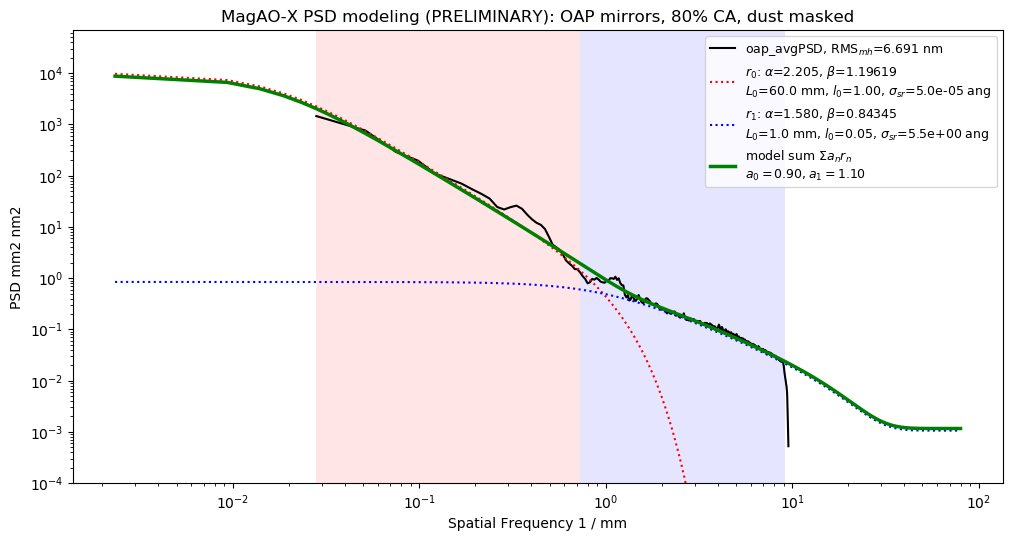

In [44]:
color_list=['r', 'b','y']
plt.figure(figsize=[12,6], dpi=100)
plt.loglog(avg_psd.k_radial.value, avg_psd.psd_radial_cal.value, 'k', label='{0}, RMS{1}={2:.3f}'.format(avg_psd.surf_name,r'$_{mh}$', avg_psd.rms_mh))
for j in range(0, len(i_start)):
    plt.loglog(mdl_set[j].k_extend.value, mdl_set[j].psd_full.value, color_list[j]+':', linewidth=1.5,
               label='{0}: {1}={2:.3f}, {3}={4:.5f}\n{5}={6:.1f}, {7}={8:.2f}, {9}={10:.1e} ang'.format(r'$r_{0}$'.format(mdl_set[j].region_num), r'$\alpha$', mdl_set[j].alpha, 
                                                                                                    r'$\beta$', mdl_set[j].beta.value, r'$L_{0}$',L0[j], r'$l_{0}$', lo[j], 
                                                                                                    r'$\sigma_{sr}$', rms_sr[j].to(u.angstrom).value))
    plt.axvspan(avg_psd.k_radial[i_start[j]].value, avg_psd.k_radial[i_end[j]].value, facecolor=color_list[j], alpha=0.1)
txt_print = r'$a_{0}={1:.2f}, a_{2}={3:.2f}$'.format(0, psd_scl[0][0], 1, psd_scl[0][1])
plt.loglog(mdl_set[0].k_extend.value, mdl_sum[0], 'g', linewidth=2.5, label='model sum {0}\n{1}'.format(r'$\Sigma a_{n}r_{n}$', txt_print))
plt.ylim(bottom=1e-4)
plt.xlabel('Spatial Frequency {0}'.format(avg_psd.k_radial.unit))
plt.ylabel('PSD {0}'.format(avg_psd.psd_radial_cal.unit))
plt.title('MagAO-X PSD modeling (PRELIMINARY): OAP mirrors, {0}% CA, dust masked'.format(opt_parms['ca']))
plt.legend(prop={'size':9})#,loc='center left', bbox_to_anchor=(1, 0.5))

In [45]:
psd_parm = []
for j in range(0, len(mdl_set)):
    parameters = [mdl_set[j].alpha, mdl_set[j].beta, mdl_set[j].L0, mdl_set[j].lo, mdl_set[j].bsr]
    psd_parm.append(parameters)
    
psd_dict = {'psd_oap': psd_parm,
            'psd_oap_weight': psd_scl[0]}

# save the directory as a pickle
filename='/home/jhen/XWCL/code/MagAOX/PSD/psd_parms_oap.pickle'
with open(filename,'wb') as psd_parameter_file:
    pickle.dump(psd_dict, psd_parameter_file, protocol=4)

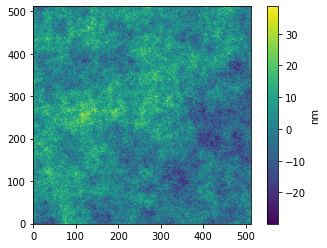

In [49]:
sg = psd.surfgen(dx=6.1524325E-02*u.mm, npix_diam=512, oversamp=2048)
sg.calc_psd(psd_parm=psd_parm, psd_weight=psd_scl[0])
sg.build_surf(opd_reflect=False)

plt.imshow(sg.surface.value, origin='lower')
plt.colorbar().set_label(sg.surface.unit)

## Regional mapping
Preliminary insight to visually choosing regions with fit best for simple model. Kept here for reference.

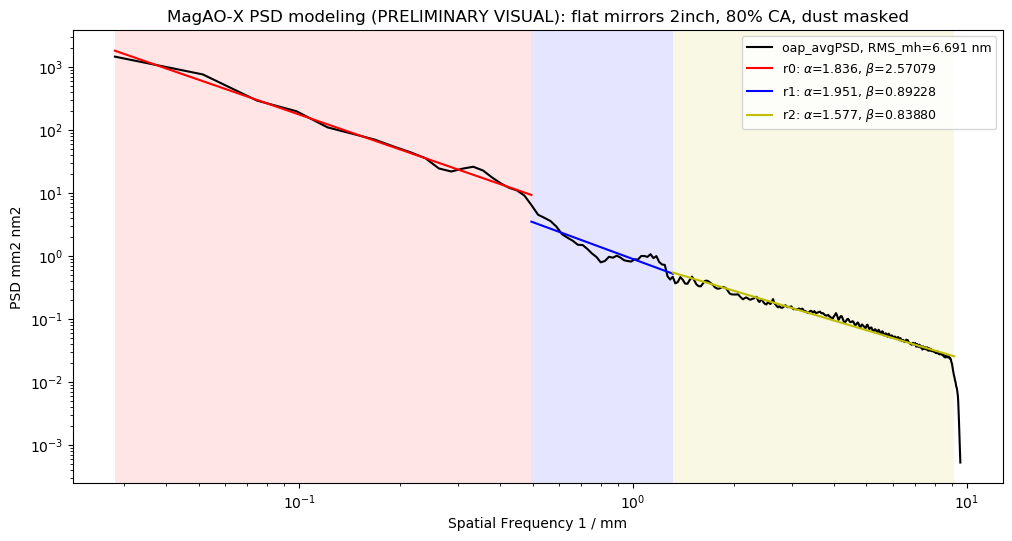

In [12]:
i_start = [0, 20, 55]
i_end = i_start[1:]
i_end.append(390) # cut off the big dip end

mdl_simp = []
for j in range(0, len(i_start)):
    mdl = psd.model(region_num=j, ind_start=i_start[j], ind_end=i_end[j],
                k_radial=avg_psd.k_radial, p_radial=avg_psd.psd_radial_cal,
                k_min=avg_psd.k_min, k_max=avg_psd.k_max)
    mdl.solve_lsf()
    mdl.calc_model_simple(k_range=mdl.k_data)
    mdl_simp.append(mdl)

alpha_tone = 0.1
color_list=['r', 'b','y']
plt.figure(figsize=[12,6],dpi=100)
plt.loglog(avg_psd.k_radial.value, avg_psd.psd_radial_cal.value, 'k', label='{0}, RMS_mh={1:.3f}'.format(avg_psd.surf_name, avg_psd.rms_mh))
for j in range(0, len(i_start)):
    plt.loglog(mdl_simp[j].k_data.value, mdl_simp[j].psd_simple.value, color_list[j], linewidth=1.5,
               label='r{0}: {1}={2:.3f}, {3}={4:.5f}'.format(mdl_simp[j].region_num, r'$\alpha$', mdl_simp[j].alpha, r'$\beta$', mdl_simp[j].beta.value))
    plt.axvspan(avg_psd.k_radial[i_start[j]].value, avg_psd.k_radial[i_end[j]].value, 
                facecolor=color_list[j], alpha=alpha_tone)
plt.xlabel('Spatial Frequency {0}'.format(avg_psd.k_radial.unit))
plt.ylabel('PSD {0}'.format(avg_psd.psd_radial_cal.unit))
plt.title('MagAO-X PSD modeling (PRELIMINARY VISUAL): flat mirrors 2inch, {0}% CA, dust masked'.format(opt_parms['ca']))
plt.legend(prop={'size':9})#,loc='center left', bbox_to_anchor=(1, 0.5))

In [9]:
# solve for the LSF values of alpha and beta
# cut off the high frequency slump at the end
k_range = oap[0].k_radial[np.log10(oap[0].k_radial.value)<0.95] # in log scale, this is the cutoff
avg_cpsd = avg_psd_cal[0:len(k_range)]
la, lb = psd.solve_model_lsf(avg_cpsd, k_range)

# calculate average surface roughness rms
sr_rms = [0.51, 0.54, 1.00, 0.59, 0.5, 0.41, 0.44, 0.43] * u.nm
avg_sr_rms = np.mean(sr_rms)
bsr = psd.calc_bsr(rms_sr = avg_sr_rms, k_min = oap[0].k_min, k_max = oap[0].k_max)
bsr
# all OAPs sampled same, so have same k_min and k_max

/home/jhen/XWCL/code/MagAOX/functions/psd_functions.py:237: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m,c = np.linalg.lstsq(A, y)[0] # y = mx + c linear equation


<Quantity 0.00105786 mm2 nm2>

In [10]:
# Expand spatial freq range to see where the model takes us with the data

# concatenate array for front
last = np.min(k_range) - oap[0].delta_k # initialize
front_fill = []
while last.value>0:
    front_fill.append(last.value)
    last = last - oap[0].delta_k
front_k = np.hstack((np.asarray(front_fill[::-1]), np.asarray(oap[0].k_radial.value)))

# concatenate array for end
nex_pts = 800
dkr = (oap[0].k_radial[1] - oap[0].k_radial[0]).value
dkr_mult = 3
rear_fill = [(np.amax(oap[0].k_radial.value) + (dkr*dkr_mult))]
for i in range(1, nex_pts): rear_fill.append(rear_fill[i-1] + (dkr*dkr_mult))
new_k = np.hstack((front_k, np.asarray(rear_fill)))*oap[0].k_radial.unit
    
#verify it all went together, should end up as 0
# np.shape(new_k)[0] - len(front_fill) - len(rear_fill) - len(oap[0].k_radial)
new_k

<Quantity [4.67966642e-03, 9.35933285e-03, 1.40389993e-02, ...,
           6.55668063e+01, 6.56370013e+01, 6.57071963e+01] 1 / mm>

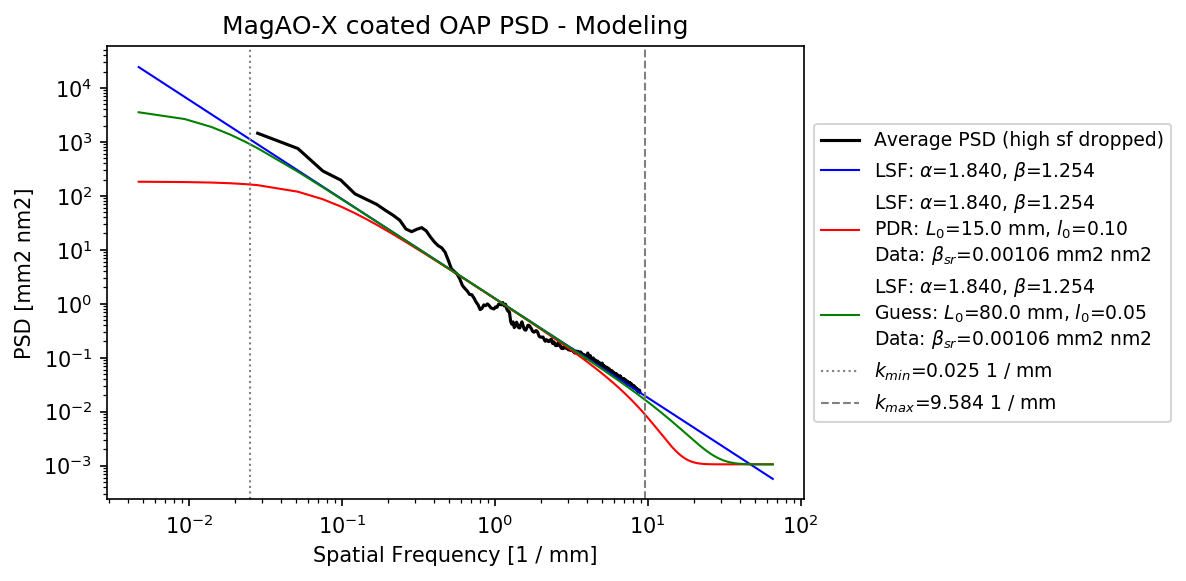

In [11]:
# extend k-range for LSF
p_lsf_ext = psd.calc_model_simple(new_k, la, lb)

# PDR L's
lo = 0.1
L0 = 15*u.mm
p_full = psd.calc_model_full(new_k, la, lb, L0, lo, bsr)

# guessing the L's
g_lo = 0.05
g_L0 = 80*u.mm
p_full_guess = psd.calc_model_full(new_k, la, lb, g_L0, g_lo, bsr)

# check the plots
plt.figure(dpi=150)
plt.loglog(k_range, avg_cpsd, 'k', linewidth=1.5, label='Average PSD (high sf dropped)')
plt.loglog(new_k, p_lsf_ext, 'b', linewidth=1,
           label='LSF: {0}={1:.3f}, {2}={3:.3f}'.format(r'$\alpha$', la, r'$\beta$', lb.value))
plt.loglog(new_k, p_full, 'r', linewidth=1,
           label='LSF: {0}={1:.3f}, {2}={3:.3f}\nPDR: {4}={5}, {6}={7:.2f}\nData: {8}={9:.5f}'.format(r'$\alpha$', la, 
                                                                         r'$\beta$', lb.value, 
                                                                         r'$L_{0}$',L0, 
                                                                         r'$l_{0}$', lo,
                                                                         r'$\beta_{sr}$', bsr))
plt.loglog(new_k, p_full_guess, 'g', linewidth=1,
           label='LSF: {0}={1:.3f}, {2}={3:.3f}\nGuess: {4}={5}, {6}={7:.2f}\nData: {8}={9:.5f}'.format(r'$\alpha$', la, 
                                                                         r'$\beta$', lb.value, 
                                                                         r'$L_{0}$', g_L0, 
                                                                         r'$l_{0}$', g_lo,
                                                                         r'$\beta_{sr}$', bsr))
plt.axvline(x=oap[0].k_min.value, color='grey', ls=':', label='{0}={1:.3f}'.format(r'$k_{min}$', oap[0].k_min), linewidth=1)
plt.axvline(x=oap[0].k_max.value, color='grey', ls='--', label='{0}={1:.3f}'.format(r'$k_{max}$', oap[0].k_max), linewidth=1)
plt.xlabel('Spatial Frequency [{0}]'.format(oap[0].k_radial.unit))
plt.ylabel('PSD [{0}]'.format(avg_psd_cal.unit))
plt.title('MagAO-X coated OAP PSD - Modeling')
plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))

In [16]:
bsr

<Quantity 0.00105786 mm2 nm2>

In [21]:
from scipy.optimize import curve_fit
def model_lo_L0(k, alpha, beta, lo, L0, bsr):
    #return ((beta*np.exp(-(k*lo)**2)) / ( ((L0**-2) + (k**2))**(alpha/2) )) + bsr
    return (beta*np.exp(-(k*lo)**2)/(k**alpha)) + bsr

def model_lo(k, lo):
    # hard-coded from past calculations
    alpha = 1.8395337855459057 # linear LSF
    beta = 1.2542724 # linear LSF
    bsr = 0.0010578594 # calculated from data
    return (beta*np.exp(-(k*lo)**2)/(k**alpha)) + bsr

popt, pcov = curve_fit(model_lo, k_range.value, avg_cpsd.value)
popt

array([-5.45857637e-06])

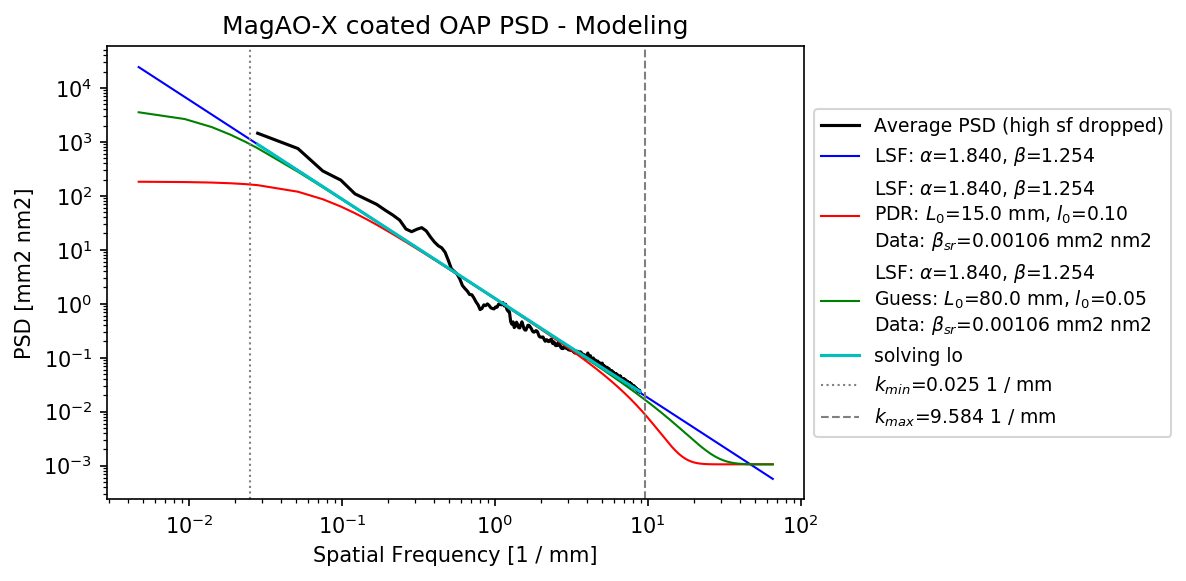

In [22]:
psd_lo = model_lo(k=k_range.value,lo=popt[0])
# check the plots
plt.figure(dpi=150)
plt.loglog(k_range, avg_cpsd, 'k', linewidth=1.5, label='Average PSD (high sf dropped)')
plt.loglog(new_k, p_lsf_ext, 'b', linewidth=1,
           label='LSF: {0}={1:.3f}, {2}={3:.3f}'.format(r'$\alpha$', la, r'$\beta$', lb.value))
plt.loglog(new_k, p_full, 'r', linewidth=1,
           label='LSF: {0}={1:.3f}, {2}={3:.3f}\nPDR: {4}={5}, {6}={7:.2f}\nData: {8}={9:.5f}'.format(r'$\alpha$', la, 
                                                                         r'$\beta$', lb.value, 
                                                                         r'$L_{0}$',L0, 
                                                                         r'$l_{0}$', lo,
                                                                         r'$\beta_{sr}$', bsr))
plt.loglog(new_k, p_full_guess, 'g', linewidth=1,
           label='LSF: {0}={1:.3f}, {2}={3:.3f}\nGuess: {4}={5}, {6}={7:.2f}\nData: {8}={9:.5f}'.format(r'$\alpha$', la, 
                                                                         r'$\beta$', lb.value, 
                                                                         r'$L_{0}$', g_L0, 
                                                                         r'$l_{0}$', g_lo,
                                                                         r'$\beta_{sr}$', bsr))
plt.loglog(k_range, psd_lo, 'c', label='solving lo')
plt.axvline(x=oap[0].k_min.value, color='grey', ls=':', label='{0}={1:.3f}'.format(r'$k_{min}$', oap[0].k_min), linewidth=1)
plt.axvline(x=oap[0].k_max.value, color='grey', ls='--', label='{0}={1:.3f}'.format(r'$k_{max}$', oap[0].k_max), linewidth=1)
plt.xlabel('Spatial Frequency [{0}]'.format(oap[0].k_radial.unit))
plt.ylabel('PSD [{0}]'.format(avg_psd_cal.unit))
plt.title('MagAO-X coated OAP PSD - Modeling')
plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))